# 1. Basic operations

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

In [2]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model
from pipeGEM.utils import get_subsystems
import cobra

## Get model from [BiGG](http://bigg.ucsd.edu/) or [Metabolic atlas](https://metabolicatlas.org/)

In [3]:
model_list = list_models(organism="E. coli")

In [4]:
model_list.head()

,id,organism,reaction_count,metabolite_count,gene_count,database
0,e_coli_core,Escherichia coli str. K-12 substr. MG1655,95,72,137,BiGG
2,iAF1260,Escherichia coli str. K-12 substr. MG1655,2382,1668,1261,BiGG
3,iAF1260b,Escherichia coli str. K-12 substr. MG1655,2388,1668,1261,BiGG
11,iAPECO1_1312,Escherichia coli APEC O1,2735,1942,1313,BiGG
13,iB21_1397,Escherichia coli BL21(DE3),2741,1943,1337,BiGG


In [8]:
ecoli = load_remote_model("e_coli_core")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


In [6]:
ecoli

Name,e_coli_core
Memory address,0x022ab568b1c0
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


## Create Model object

In [7]:
pg_mod = pg.Model(model=ecoli, name_tag="ecoli")

In [8]:
pg_mod

Name,e_coli_core
Memory address,0x022ab568b1c0
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [9]:
# basic information

pg_mod.n_rxns, pg_mod.n_genes, pg_mod.n_mets

(95, 137, 72)

In [10]:
# flux analysis using get_flux

pFBA_result = pg_mod.do_flux_analysis(method="pFBA")

In [12]:
pFBA_result

            fluxes  reduced_costs
PFK       7.477382      -2.000000
PFL       0.000000       5.733333
PGI       4.860861      -2.000000
PGK     -16.023526       2.000000
PGL       4.959985      -2.000000
...            ...            ...
NADH16   38.534610      -2.000000
NADTRHD   0.000000       1.422222
NH4t      4.765319      -2.000000
O2t      21.799493      -2.000000
PDH       9.282533      -2.000000

[95 rows x 2 columns]

In [32]:
pFBA_result.plot(rxn_ids=["PFK", "PGI", "PGK"])

KeyError: 'Reaction'

In [11]:
# flux sampling using get_flux

sampling_result = pg_mod.do_flux_analysis(method="sampling", n=30)

Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp9c4_u9xy.lp
Reading time = 0.00 seconds
: 73 rows, 190 columns, 722 nonzeros


In [16]:
sampling_result.result[0]

,rxn_id,flux
0,PFK,7.920329
1,PFL,5.396445
2,PGI,4.685600
3,PGK,-16.381815
4,PGL,5.132838
...,...,...
90,NADH16,37.693630
91,NADTRHD,5.777644
92,NH4t,3.745024
93,O2t,21.493428


## Create Group object

In [6]:
from pipeGEM.utils import random_perturb

In [9]:
# create different models
models = [random_perturb(ecoli, 
                         in_place=False, 
                         structure_ratio=0.8,
                         constr_ratio=0.8, 
                         random_state=i) for i in range(9)]

Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpu7iyyo0z.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpussg6iw5.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp19a5l8gf.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp51au7sf0.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpjul0vqvp.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmprbzcf_p6.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp99hs_ujn.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns

In [22]:
# The first way to initialize Group is to use a dict of cobra.model dicts (str as keys)

grp = pg.Group({"G1": {f"m{i+1}": models[i] for i in range(3)},
               "G2": {f"m{i+1}": models[i] for i in range(3, 6)},
               "G3": {f"m{i+1}": models[i] for i in range(6, 9)}}, name_tag="group")

In [23]:
# browse the group structure

grp

Group [group]
├── [0] G1 (Group) ── 3
├── [1] G2 (Group) ── 3
└── [2] G3 (Group) ── 3

In [24]:
# browse the group table

grp.get_info()

,group_0,group_1,group_2
0,group,G1,m1
1,group,G1,m2
2,group,G1,m3
3,group,G2,m4
4,group,G2,m5
5,group,G2,m6
6,group,G3,m7
7,group,G3,m8
8,group,G3,m9


In [25]:
# select one group / model by name_tag

grp["G1"]

Group [G1]
├── [0] m1 (Model)
├── [1] m2 (Model)
└── [2] m3 (Model)

In [26]:
grp["G1"].get_info()

,group_0,group_1
0,G1,m1
1,G1,m2
2,G1,m3


In [27]:
# The models will become pg.Model

type(grp["G1"]["m1"])

pipeGEM.core._model.Model

In [30]:
# The second way to initialize Group is to use a dict of pipeGEM.Model lists

grp = pg.Group({"G1": [pg.Model(f"m{i+1}", models[i]) for i in range(3)],
               "G2": [pg.Model(f"m{i+1}", models[i]) for i in range(3, 6)],
               "G3": [pg.Model(f"m{i+1}", models[i]) for i in range(6, 9)]}, name_tag="group")

## Comparisons

In [98]:
# compare model components

comparison = grp.compare(use="jaccard")

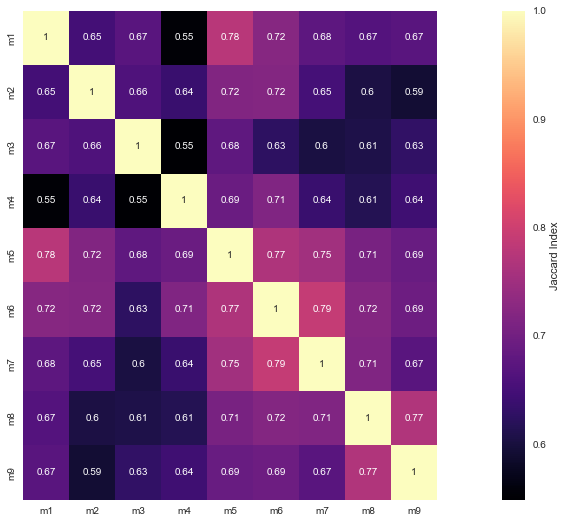

In [100]:
# visualization

comparison.plot()

In [101]:
# data frame showing the jaccard values
comparison

          m1        m2        m3        m4        m5        m6        m7  \
m1  1.000000  0.648084  0.671587  0.552901  0.776224  0.722222  0.677083   
m2  0.648084  1.000000  0.660517  0.637681  0.717687  0.717770  0.649485   
m3  0.671587  0.660517  1.000000  0.548387  0.678201  0.625430  0.602787   
m4  0.552901  0.637681  0.548387  1.000000  0.690972  0.714801  0.638298   
m5  0.776224  0.717687  0.678201  0.690972  1.000000  0.765886  0.751701   
m6  0.722222  0.717770  0.625430  0.714801  0.765886  1.000000  0.790036   
m7  0.677083  0.649485  0.602787  0.638298  0.751701  0.790036  1.000000   
m8  0.665493  0.604096  0.607143  0.614286  0.706081  0.717770  0.714286   
m9  0.670251  0.591065  0.628676  0.642066  0.688136  0.693380  0.671378   

          m8        m9  
m1  0.665493  0.670251  
m2  0.604096  0.591065  
m3  0.607143  0.628676  
m4  0.614286  0.642066  
m5  0.706081  0.688136  
m6  0.717770  0.693380  
m7  0.714286  0.671378  
m8  1.000000  0.767176  
m9  0.767176  

In [112]:
comparison = grp.compare(use="PCA", compare_models=False, n_components=5)

saving  PCA.png


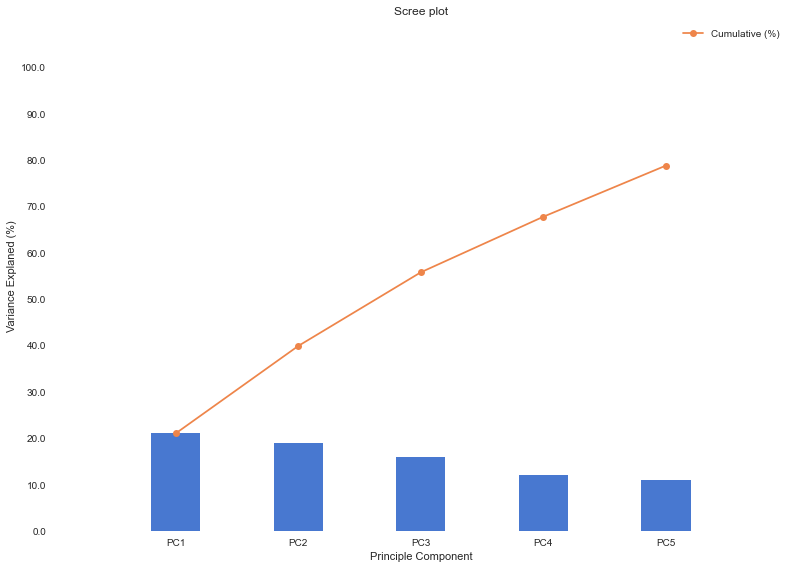

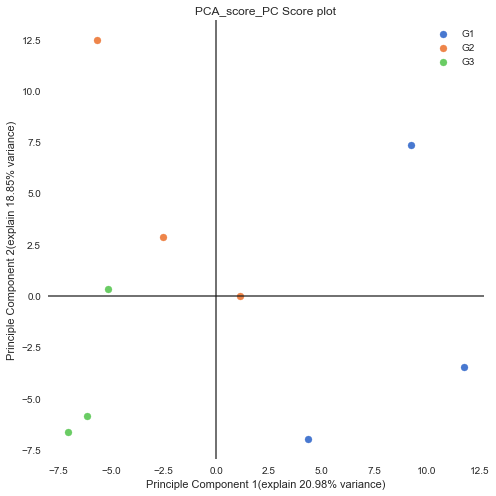

In [114]:
comparison.plot(file_name="PCA.png", prefix="")

In [70]:
comparison = grp.compare(compare_models=False, use="num", present_lvl=2)

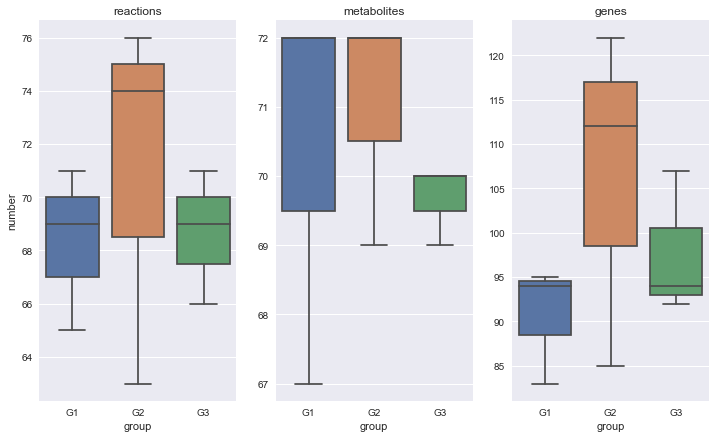

In [72]:
comparison.plot(group="group", name_order="default")